In [387]:
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext.data
import random
import matplotlib.pyplot as matpy
import math
import re
import ipdb

torch.cuda.manual_seed(1)


In [388]:
class RelationClassifier(nn.Module):
    # Module which implements the model
    def __init__ (self,input_dim, hidden_dim, output_dim):
        nn.Module.__init__(self)
        
        self.linear_input = nn.Linear(input_dim,hidden_dim)
        self.linear_hidden = nn.Linear(hidden_dim,output_dim)
        
    def forward(self, batch_input_vector, label_size):
        
        batch_size = len(batch_input_vector) 
        batch_op = np.zeros((batch_size,label_size)) #how is it 8?
        batch_output = autograd.Variable(torch.cuda.FloatTensor(batch_op), requires_grad=True)
       
        
        hidden_layer = self.linear_input(batch_input_vector)
        hidden_units = F.tanh(hidden_layer)
        batch_output = self.linear_hidden(hidden_units)
        
        return(F.log_softmax(batch_output))
    

In [389]:
class modelData:
    
    def __init__(self, blessFile):

        with open(blessFile) as inputFile:

                content = [line.strip('\n') for line in inputFile.readlines()]

                totalData = len(content) 
                #60% train, 10% dev, 30% test
                self.trainData  = content[1:int(totalData*.6)]
                self.devData    = content[int(totalData*.6):int(totalData*.7)]
                self.testData   = content[int(totalData*.7):]

        inputFile.close()
        self.devCount = len(self.devData)
        self.trainCount = len(self.trainData)
        self.testCount = len(self.testData)
        
    def create_labelsToIndex(self):
        
        self.labelsToIndex = dict()
        
        for dataset in [self.trainData, self.testData, self.devData]:
            for data in dataset:
                split_data = data.split(', ')
                tempRelation = split_data[2].strip("[']")

                if tempRelation not in self.labelsToIndex:
                    self.labelsToIndex[tempRelation] = len(self.labelsToIndex)

        return len(self.labelsToIndex)

    def shuffle_data(self):
        indices = list(range(self.trainCount))
        random.shuffle(indices)
        newTrainData = [self.trainData[i] for i in indices]
        self.trainData = newTrainData
    
    def create_dictVectors(self,embeddingFile):
        
        self.dictRelVectors = dict()
        with open(embeddingFile) as inputFile:
    
            for Vectors in inputFile:
                vec = Vectors.split()
                try:
                    vec[2]
                    self.dictRelVectors[vec[0]] = vec[1:]
                except:
                    input_dim = int(vec[1])
        
        inputFile.close()
        return input_dim

    def make_batch_input_vector(self,batch_target,batch_relata):

        batch_relation_vector = []
        for (target,relata) in zip(batch_target,batch_relata):

            #word1 = target.lower()
            #word2 = relata.lower()
            #collect the respective vectors for word 1 & 2

            #vector_1 = np.array(dict_Vectors[word1])
            #vector_1 = np.ndarray.astype(vector_1,float)
            #vector_2 = np.array(dict_Vectors[word2])
            #vector_2 = np.ndarray.astype(vector_2,float)

            #Combine these two vectors to form a single vector
            #vector_1 - vector_2

            key = target+':::'+relata
            relation_vector = [float(value) for value in self.dictRelVectors[key]] 

            batch_relation_vector.append(relation_vector)


        return(torch.cuda.FloatTensor(batch_relation_vector))

    def make_batch_target_vector(self, batch_relation):
    
        batch_relation_indices = []

        for relation in batch_relation:
            batch_relation_indices.append(self.labelsToIndex[relation])
            #print(torch.cuda.LongTensor(batch_relation_indices))
        return(torch.cuda.LongTensor(batch_relation_indices))

    
    def make_input_vector(self,target,relata):

        #word1 = target.lower()
        #word2 = relata.lower()

        #collect the respective vectors for word 1 & 2
        #vector_1 = np.array(dict_Vectors[word1])
        #vector_1 = np.ndarray.astype(vector_1,float)
        #vector_2 = np.array(dict_Vectors[word2])
        #vector_2 = np.ndarray.astype(vector_2,float)

        #Combine these two vectors to form a single vector

        key = target+":::"+relata
        relation_vector = [float(value) for value in self.dictRelVectors[key]] 
        tensor = torch.cuda.FloatTensor(relation_vector)


        return(tensor)

In [390]:
#TRAINING

def train(labelCount):

    batchSize = 2                   #batch size
    epochCost = []
    epochs = 10


    for epoch in range(epochs):

        #SPlit dataset to avoid lexical memorization
        print("Epoch :", epoch)
        inputData.shuffle_data()

        N = math.ceil(len(inputData.trainData)/bs)

        Train_Error_cost = []
        Average_cost = 0

        for i in range(N):

            batch_entry = inputData.trainData[i*bs:i*bs+bs]
            batch_concept = []
            batch_relata = []
            batch_relation = []

            for index,data in enumerate(batch_entry):

                split_data = data.split(', ')

                tempConcept = split_data[0].strip("[']")
                tempRelata = split_data[1].strip(" '")
                tempRelation = split_data[2].strip("[']")

                batch_concept.append(tempConcept)
                batch_relata.append(tempRelata)
                batch_relation.append(tempRelation)


            batch_input_vector = autograd.Variable(inputData.make_batch_input_vector(batch_concept,batch_relata), requires_grad = True)
            batch_target_label = autograd.Variable(inputData.make_batch_target_vector(batch_relation))

            model.zero_grad() 
            batch_log_prob = model(batch_input_vector, labelCount)
            batch_cost = loss(batch_log_prob,batch_target_label)

            batch_cost.backward()
            optimizer.step()

            Train_Error_cost.append(batch_cost.data.tolist())
            Average_cost += batch_cost.data.tolist().pop()
            
            #print(batch_cost.data, Train_Error_cost, Average_cost)

        temp = Average_cost/len(inputData.trainData)

        epochCost.append(temp)
        
    return epochCost
     

In [391]:
def plot_results(epoch_cost,xlabel):
    matpy.plot(epoch_cost)
    matpy.ylabel("Average cost")
    matpy.xlabel(xlabel)
    matpy.show()

In [393]:
def validate(labelCount):
    
    count = 0
    Dev_Error_cost = []

    for data in inputData.devData:

        split_data = data.split(', ')

        tempConcept = split_data[0].strip("[']")
        tempRelata = split_data[1].strip(" '")
        tempRelation = split_data[2].strip("[']")


        input_vector = autograd.Variable(inputData.make_input_vector(tempConcept,tempRelata))
        target_label = autograd.Variable(torch.cuda.LongTensor([inputData.labelsToIndex[tempRelation]]))

        log_prob = model(input_vector, labelCount)
        log_prob = log_prob.view(1,-1)
        predict_label = log_prob.max(0)[1]

    
        dev_cost = loss(log_prob,target_label)
        Dev_Error_cost.append(dev_cost.data.tolist())

        if(str(predict_label.data) == str(target_label.data)):     
            count += 1

    print("Error for Dev set", Dev_Error_cost)
    print("Accuracy",(count/len(inputData.devData))*100)
    
    return Dev_Error_cost


In [394]:
def test(labelCount):
    
    count = 0
    Test_Error_cost = []

    for data in inputData.testData:

        split_data = data.split(', ')

        tempConcept = split_data[0].strip("[']")
        tempRelata = split_data[1].strip(" '")
        tempRelation = split_data[2].strip("[']")


        input_vector = autograd.Variable(inputData.make_input_vector(tempConcept,tempRelata))
        target_label = autograd.Variable(torch.cuda.LongTensor([inputData.labelsToIndex[tempRelation]]))

        log_prob = model(input_vector, labelCount)
        log_prob = log_prob.view(1,-1)
        predict_label = log_prob.max(0)[1]

        test_cost = loss(log_prob,target_label)
        Test_Error_cost.append(test_cost.data.tolist())

        if(str(predict_label.data) == str(target_label.data)):     
            count += 1

    print("Error for Test set", Test_Error_cost)
    print("Accuracy",(count/len(inputData.testData))*100)
    
    return Test_Error_cost


Epoch : 0
Epoch : 1
Epoch : 2
Epoch : 3
Epoch : 4
Epoch : 5
Epoch : 6
Epoch : 7
Epoch : 8
Epoch : 9


/home/achingacham/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


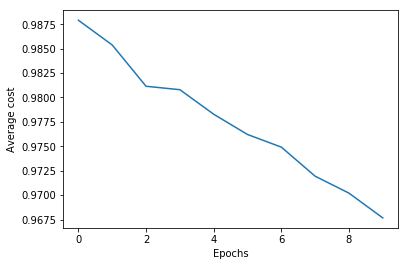

Error for Dev set [[1.8394832611083984], [1.7387381792068481]]
Accuracy 0.0


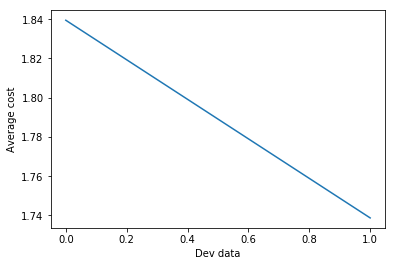

Error for Test set [[1.782066822052002], [1.784256935119629], [1.7400257587432861], [1.7401950359344482], [1.7399482727050781], [1.7794588804244995]]
Accuracy 0.0


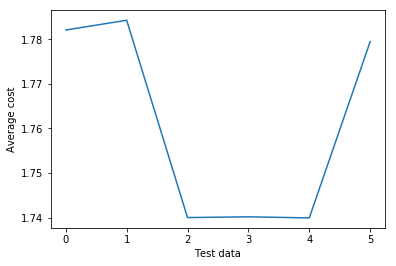

In [395]:

if __name__ == '__main__':
    
    #DATA

    inputData = modelData("/home/achingacham/Model/GRID_data/UkWAC/SplitFiles/OutputSample/BlessSet(training).txt")
    inputDim = inputData.create_dictVectors("/home/achingacham/Model/GRID_data/UkWAC/SplitFiles/OutputSample/EMB_bless.txt_Bless")

    #MODEL
    INPUT_DIM = inputDim
    HIDDEN_UNIT = inputDim 
    OUTPUT_LABEL = inputData.create_labelsToIndex()


    model = RelationClassifier(INPUT_DIM, HIDDEN_UNIT, OUTPUT_LABEL)
    loss = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.0025)

    if torch.cuda.is_available():
        model.cuda()
        pass
    
    train_cost = train(OUTPUT_LABEL)
    plot_results(train_cost, "Epochs")
    dev_cost = validate(OUTPUT_LABEL)
    plot_results(dev_cost, "Dev data")
    test_cost = test(OUTPUT_LABEL)
    plot_results(test_cost, "Test data")
    
